<div align = "center"><font size = "5"> Quantitative Analytics_Case Study_Coding Challenge </font></div>  

<div align = "center"><font size = "4">  December 2023 </font></div>  

<div align = "center"><font size = "4">  Author: Yi-Lung (Dragon) Tsai </font></div>  

*** 


### Task 1
There are two csv files attached containing financial time series representing the price of two futures 
contracts, A and B, respectively. We would like you to write code that:

* Loads the data from the CVSs into memory.
* Implements the following systematic trading strategy:
     - Buys or maintains a long position of size L>0 in futures A every time the price of futures B falls more than X standard deviations (calculated over the previous N days) in a day.
     - Sells or maintains a short position of size S<0 in futures A every time the price of futures B rises more than Y standard deviations (calculated over the previous N days) in a day.
     - Closes any position in futures A if neither of the above two conditions are met.
     - The strategy pays costs of C x abs(size) each time it trades.
* Produces a chart of cumulative profit and loss of the strategy over time
* Produces a chart of drawdown (absolute loss at time T / maximum achieved profit before T) over time
* Prints the annualised return, Sharpe ratio and max(drawdown) of the strategy where X, Y and N, L, S, C are user defined variables.

You are free to use any open-source libraries. You may assume that:
   *  The risk-free rate is zero.
   *  You are allowed to take a short position on a futures contract (i.e., the net number of futures contracts of the same type in instantaneous possession may be negative.)
    
The code you write should be modular and easily allow additional trading strategies to be analysed on 
different datasets. We recommend that you use object-oriented programming.

We are primarily interested in your coding approach here and not the profit or loss of the strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

futures_A = pd.read_csv("C:/Users/user/Desktop/futuresA.csv")  # Read the CSV file from the specified path in my laptop
futures_B = pd.read_csv("C:/Users/user/Desktop/futuresB.csv")

futures_A.columns = ['Date', 'Close_A']
futures_B.columns = ['Date', 'Close_B']

In [2]:
futures_df = pd.merge(futures_A, futures_B) # Merge dataframes futures_A and futures_B based on a common column
futures_df['Date'] = pd.DatetimeIndex(futures_df['Date'])
futures_df = futures_df[::-1] # Reverse the order of rows in the dataframe
futures_df = futures_df.reset_index(drop=True) # Reset the index of the dataframe after reversing the order
futures_df

C:\Users\user\AppData\Local\Temp\ipykernel_23684\385960851.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  futures_df['Date'] = pd.DatetimeIndex(futures_df['Date'])


,Date,Close_A,Close_B
0,1988-05-20,85.43750,96.953125
1,1988-05-23,85.31250,96.796875
2,1988-05-24,85.46880,96.812500
3,1988-05-25,85.75000,96.890625
4,1988-05-26,85.65620,96.765625
...,...,...,...
7645,2018-10-22,137.68750,112.085938
7646,2018-10-23,138.18750,112.265625
7647,2018-10-24,139.06250,112.484375
7648,2018-10-25,138.84375,112.421875


#### Here I will use  Bollinger Bands to be my signal.

> #### Introduction:
> A Bollinger Band constitutes a technical analysis instrument characterized by a series of trendlines. These lines are drawn at two standard deviations, both in a positive and negative direction, from a simple moving average (SMA) of the price of a financial instrument. 
>
>Bollinger Bands was developed by technical trader John Bollinger and designed to give investors a higher probability of identifying when an asset is oversold or overbought.
>
> #### Formula:
>
> * $BOLU=MA(TP,n)+m∗σ[TP,n]$
> * $BOLD=MA(TP,n)−m∗σ[TP,n]$ 
>  #### where: ####
> * $BOLU=Upper Bollinger Band$
> * $BOLD=Lower Bollinger Band$
> * $MA=Moving$ $average$
> * $TP$ ($typical$ $price$)$=$$(High+Low+Close)÷3$
> * $n$$=$$Number$ $of$ $days$ $in$ $smoothing period$ $(typically$ $20)$
> * $m$$=$$Number$ $of$ $standard$ $deviations$ $(typically$ $2)$
> * $σ[TP,n]$$=$$Standard$ $Deviation$ $over$ $last$ $n$ $periods$ $of$ $TP$

In [3]:
n = 22 # Define the number of trading days in a month 
futures_df['rolling_std_b'] = futures_df['Close_B'].rolling(window = n).std() # Calculate the rolling standard deviation for the 'Close_B' column
futures_df['rolling_ma_b'] = futures_df['Close_B'].rolling(window = n).mean() # Calculate the rolling mean for the 'Close_B' column
futures_df['Upper_Bolinger_Brand_Signal'] = futures_df['rolling_ma_b'] + 2 * futures_df['rolling_std_b'] # Calculate the upper Bollinger Band signal
futures_df['Lower_Bolinger_Brand_Signal'] = futures_df['rolling_ma_b'] - 2 * futures_df['rolling_std_b'] # Calculate the lower Bollinger Band signal

futures_df.tail(10)

,Date,Close_A,Close_B,rolling_std_b,rolling_ma_b,Upper_Bolinger_Brand_Signal,Lower_Bolinger_Brand_Signal
7640,2018-10-15,138.34375,112.210938,0.321892,112.460938,113.104721,111.817154
7641,2018-10-16,138.37500,112.226562,0.310062,112.430398,113.050522,111.810273
7642,2018-10-17,137.65625,112.117188,0.298425,112.394886,112.991736,111.798037
7643,2018-10-18,138.03125,112.195312,0.289822,112.369318,112.948963,111.789673
7644,2018-10-19,137.81250,112.062500,0.289874,112.342685,112.922432,111.762937
7645,2018-10-22,137.68750,112.085938,0.285972,112.316761,112.888704,111.744818
7646,2018-10-23,138.18750,112.265625,0.272730,112.296875,112.842334,111.751416
7647,2018-10-24,139.06250,112.484375,0.262107,112.287642,112.811857,111.763428
7648,2018-10-25,138.84375,112.421875,0.255014,112.279830,112.789858,111.769801
7649,2018-10-26,139.50000,112.757812,0.257694,112.281250,112.796638,111.765862


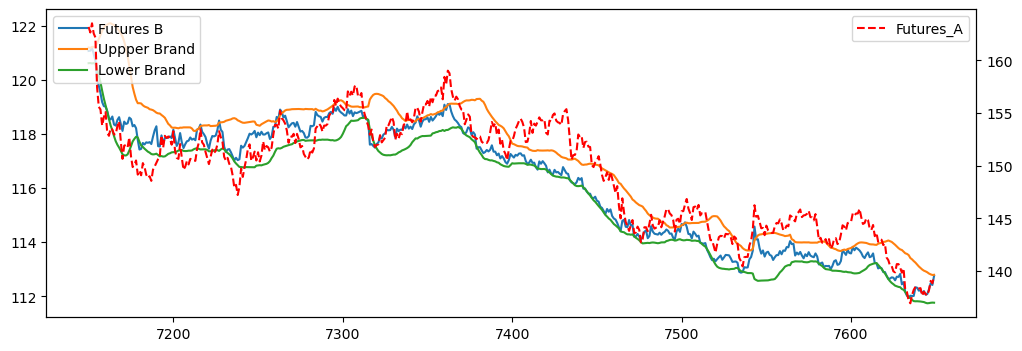

In [4]:
# Use charts to identify days when futures B trigger the Upper Bollinger Band Signal and Lower Bollinger Band Signal.
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(futures_df['Close_B'].tail(500), label = 'Futures B')
ax.plot(futures_df['Upper_Bolinger_Brand_Signal'].tail(500), label = 'Uppper Brand')
ax.plot(futures_df['Lower_Bolinger_Brand_Signal'].tail(500), label = 'Lower Brand')
ax2 = ax.twinx()
ax2.plot(futures_df['Close_A'].tail(500), color = 'red', linestyle = '--', label = 'Futures_A')

ax.legend(loc='upper left')
plt.legend()
plt.show()

In [5]:
futures_df['Long A Signal'] = (futures_df['Close_B'] > futures_df['Upper_Bolinger_Brand_Signal']) * 1    # 1 means long
futures_df['Short A Signal'] = (futures_df['Close_B'] < futures_df['Lower_Bolinger_Brand_Signal']) * -1  # -1 means short
futures_df['Overall Signal'] = futures_df['Long A Signal'] + futures_df['Short A Signal']

futures_df

,Date,Close_A,Close_B,rolling_std_b,rolling_ma_b,Upper_Bolinger_Brand_Signal,Lower_Bolinger_Brand_Signal,Long A Signal,Short A Signal,Overall Signal
0,1988-05-20,85.43750,96.953125,NaN,NaN,NaN,NaN,0,0,0
1,1988-05-23,85.31250,96.796875,NaN,NaN,NaN,NaN,0,0,0
2,1988-05-24,85.46880,96.812500,NaN,NaN,NaN,NaN,0,0,0
3,1988-05-25,85.75000,96.890625,NaN,NaN,NaN,NaN,0,0,0
4,1988-05-26,85.65620,96.765625,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7645,2018-10-22,137.68750,112.085938,0.285972,112.316761,112.888704,111.744818,0,0,0
7646,2018-10-23,138.18750,112.265625,0.272730,112.296875,112.842334,111.751416,0,0,0
7647,2018-10-24,139.06250,112.484375,0.262107,112.287642,112.811857,111.763428,0,0,0
7648,2018-10-25,138.84375,112.421875,0.255014,112.279830,112.789858,111.769801,0,0,0


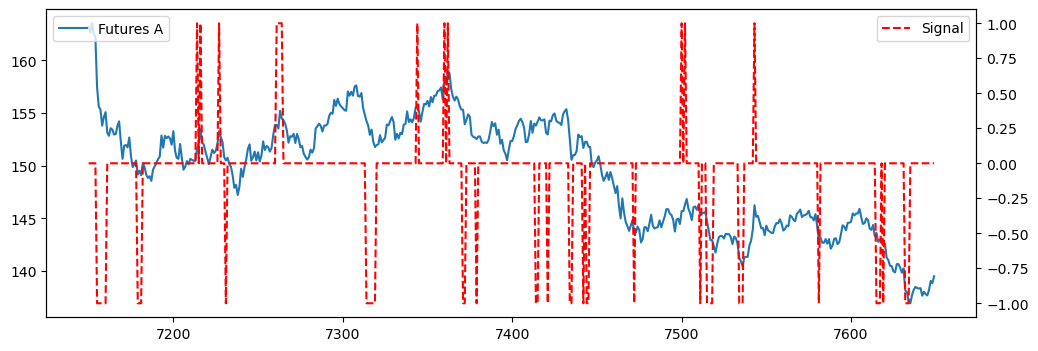

In [6]:
# Use charts to observe the buying and selling points for futures A.
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(futures_df['Close_A'].tail(500), label = 'Futures A')

ax2 = ax.twinx()
ax2.plot(futures_df['Overall Signal'].tail(500), color = 'red', linestyle = '--', label = 'Signal')

ax.legend(loc='upper left')
plt.legend()
plt.show()

In [7]:
futures_df['Strategy Return'] = futures_df['Close_A'].pct_change() * futures_df['Overall Signal'] # Calculate the daily simple return
futures_df['Strategy Return'] = futures_df['Strategy Return'].fillna(0) # The initial value of the strategy return is NaN, but I address this by replacing it with 0. This adjustment has no impact on subsequent calculations.
futures_df

,Date,Close_A,Close_B,rolling_std_b,rolling_ma_b,Upper_Bolinger_Brand_Signal,Lower_Bolinger_Brand_Signal,Long A Signal,Short A Signal,Overall Signal,Strategy Return
0,1988-05-20,85.43750,96.953125,NaN,NaN,NaN,NaN,0,0,0,0.0
1,1988-05-23,85.31250,96.796875,NaN,NaN,NaN,NaN,0,0,0,-0.0
2,1988-05-24,85.46880,96.812500,NaN,NaN,NaN,NaN,0,0,0,0.0
3,1988-05-25,85.75000,96.890625,NaN,NaN,NaN,NaN,0,0,0,0.0
4,1988-05-26,85.65620,96.765625,NaN,NaN,NaN,NaN,0,0,0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
7645,2018-10-22,137.68750,112.085938,0.285972,112.316761,112.888704,111.744818,0,0,0,-0.0
7646,2018-10-23,138.18750,112.265625,0.272730,112.296875,112.842334,111.751416,0,0,0,0.0
7647,2018-10-24,139.06250,112.484375,0.262107,112.287642,112.811857,111.763428,0,0,0,0.0
7648,2018-10-25,138.84375,112.421875,0.255014,112.279830,112.789858,111.769801,0,0,0,-0.0


In [8]:
global position_value
position_value = 100 # Set an initial position value

def calculate_profit_and_loss(return_a):
    
    global position_value
    position_value = position_value * (1 + return_a) # Update position value based on the strategy return
    
    return position_value
    
futures_df['Transaction Cost'] = futures_df['Overall Signal'].abs() * 0.02 # Transaction fee is 0.01 for each purchase and 0.01 for each sale, totaling 0.02 for each buying and selling transaction.
futures_df['Profit and Loss'] = futures_df['Strategy Return'].apply(calculate_profit_and_loss)
# Calculate the total profit and loss by subtracting transaction costs from the profit and loss
futures_df['Total P&L'] = futures_df['Profit and Loss'] - futures_df['Transaction Cost']
futures_df[50:100]

,Date,Close_A,Close_B,rolling_std_b,rolling_ma_b,Upper_Bolinger_Brand_Signal,Lower_Bolinger_Brand_Signal,Long A Signal,Short A Signal,Overall Signal,Strategy Return,Transaction Cost,Profit and Loss,Total P&L
50,1988-02-08,87.5000,97.125000,0.328484,96.940341,97.597309,96.283373,0,0,0,0.000000,0.00,100.000000,100.000000
51,1988-03-08,87.3438,97.062500,0.269275,96.906960,97.445511,96.368409,0,0,0,-0.000000,0.00,100.000000,100.000000
52,1988-04-08,87.7812,97.250000,0.230775,96.889915,97.351464,96.428365,0,0,0,0.000000,0.00,100.000000,100.000000
53,1988-05-08,86.7812,96.687500,0.203456,96.857244,97.264157,96.450331,0,0,0,-0.000000,0.00,100.000000,100.000000
54,1988-08-08,86.9688,96.656250,0.176137,96.825994,97.178269,96.473720,0,0,0,0.000000,0.00,100.000000,100.000000
55,1988-09-08,86.2188,96.250000,0.214157,96.797585,97.225898,96.369272,0,-1,-1,0.008624,0.02,100.862378,100.842378
56,1988-10-08,84.9688,95.843750,0.289024,96.743608,97.321655,96.165561,0,-1,-1,0.014498,0.02,102.324681,102.304681
57,1988-11-08,84.7812,95.796875,0.352209,96.698864,97.403281,95.994446,0,-1,-1,0.002208,0.02,102.550600,102.530600
58,1988-12-08,84.7188,95.781250,0.402873,96.656960,97.462706,95.851215,0,-1,-1,0.000736,0.02,102.626079,102.606079
59,1988-08-15,84.5312,95.750000,0.446877,96.615767,97.509521,95.722013,0,0,0,-0.000000,0.00,102.626079,102.626079


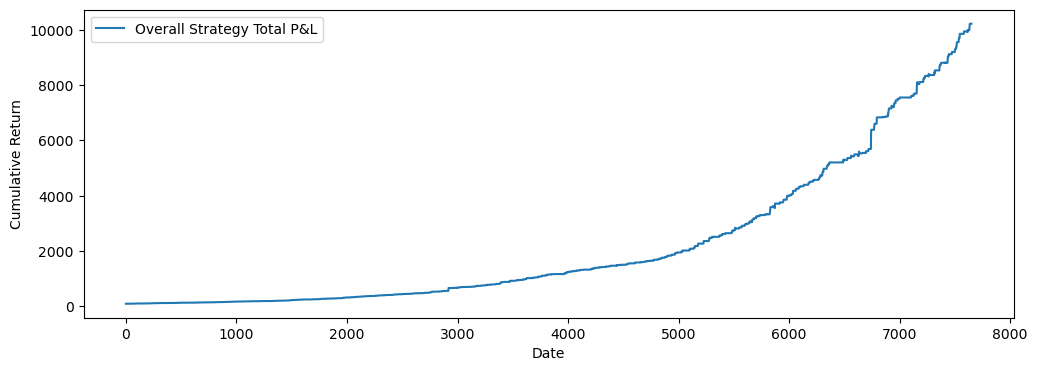

In [9]:
# Use charts to observe whether the Profit and Loss is accurate.
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(futures_df['Total P&L'], label = 'Overall Strategy Total P&L')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')

plt.legend()
plt.show()

#### The definition of Maximum Drawdown (MDD) is as follows:
> In algorithmic trading, various metrics are used to evaluate the characteristics or performance of a strategy, and one important metric is MDD (Max Drawdown), also known as 'Maximum Drawdown' or 'Maximum Decline.'

#### Definition from Wikipedia:
> The drawdown is the measure of the decline from a historical peak in some variable, typically the cumulative profit or total open equity of a financial trading strategy.


In [10]:
def Construct_Drawdown(Historical_Values,Variable_Name,DataFrame_Index,Max_Unit):
    
    """
    # Parameters Setting:
    --------------------------
    Input_Variable: 
    1.)  Historical values of "one" variable (Astype: List) 
    2.)  Variable Name (Astype: String) 
    3.)  Index for DataFrame --> Daily/Weekly/Monthly/Quarterly (Astype: List) 
    \\
    Output_Variable: 
    Maximum Drawdown Table (Astype: Pandas-DataFrame)
    
    """

    # Set up Parameters
    drawdown_df = pd.DataFrame()
    peak_values = [ Historical_Values[0] ]
    drawdown_values = [] 

    drawdown_duration = []
    drawdown_day = 0
    count_drawdown_duration = 0

    # Loop over the index range ( record historical peak date and construct maximun drawdown )
    for i in range(len(Historical_Values)):

        # compare wheather current peak values is bigger than the previous one , append the bigger one into the list.
        previous_peak_value = peak_values[i]
        current_value = Historical_Values[i]

        if drawdown_day >= Max_Unit:
            update_peak_value = current_value
        else:
            update_peak_value = max(previous_peak_value , current_value)
        
        peak_values.append( update_peak_value )  
        # lastest peak minus current equity values = current drawdown
        drawdown_values.append( update_peak_value - current_value ) 

        # drawdown duration 
        if update_peak_value - current_value == 0:
            drawdown_day = 0
            count_drawdown_duration += 1
            drawdown_duration.append(count_drawdown_duration)
        else:
            drawdown_day += 1
            # count_drawdown_duration +=1
            drawdown_duration.append(count_drawdown_duration)


    drawdown_df[str(Variable_Name)] = Historical_Values
    drawdown_df['Peak Values'] = peak_values[1:] # drop the first inital values
    drawdown_df['Drawdown Values'] = drawdown_values
    drawdown_df['Drawdown_Period_ID'] = drawdown_duration 
    drawdown_df.index = DataFrame_Index

    return drawdown_df

drawdown_df = Construct_Drawdown(Historical_Values = futures_df['Total P&L'].values, Variable_Name ='Strategy P&L', DataFrame_Index = futures_df.index, Max_Unit = 252)
drawdown_df

,Strategy P&L,Peak Values,Drawdown Values,Drawdown_Period_ID
0,100.000000,100.000000,0.0,1
1,100.000000,100.000000,0.0,2
2,100.000000,100.000000,0.0,3
3,100.000000,100.000000,0.0,4
4,100.000000,100.000000,0.0,5
...,...,...,...,...
7645,10220.932621,10220.932621,0.0,6284
7646,10220.932621,10220.932621,0.0,6285
7647,10220.932621,10220.932621,0.0,6286
7648,10220.932621,10220.932621,0.0,6287


In [11]:
# Group the drawdown_df dataframe by 'Drawdown_Period_ID' and calculate the maximum drawdown value for each group
# Reset the index and rename the resulting column to 'a'
# Sort the dataframe by the 'a' column in descending order
max_drawdown = drawdown_df.groupby('Drawdown_Period_ID')['Drawdown Values'].max().reset_index(name = 'max_drawdown').sort_values(by = 'max_drawdown', ascending = False)
max_drawdown

,Drawdown_Period_ID,max_drawdown
4858,4859,69.774791
5910,5911,67.274600
5483,5484,64.816522
5485,5486,62.699460
5699,5700,44.317012
...,...,...
2105,2106,0.000000
2104,2105,0.000000
2103,2104,0.000000
2102,2103,0.000000


In [12]:
value = max_drawdown.iloc[0]['max_drawdown']
print("max(drawdown) of the strategy is", value)

max(drawdown) of the strategy is 69.77479141539652


In [13]:
drawdown_df[drawdown_df['Drawdown_Period_ID'] == 4859]

,Strategy P&L,Peak Values,Drawdown Values,Drawdown_Period_ID
5867,3622.252645,3622.252645,0.000000,4859
5868,3554.771761,3622.252645,67.480884,4859
5869,3552.477854,3622.252645,69.774791,4859
5870,3596.769530,3622.252645,25.483116,4859


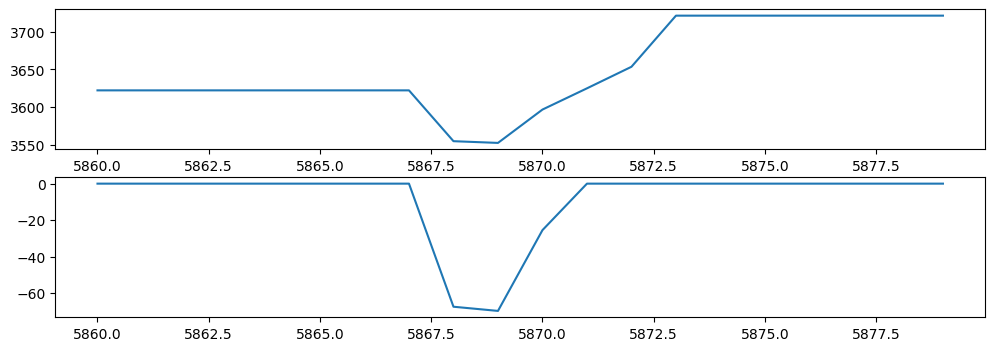

In [14]:
# Compare P&L and Drawdown Values Using Charts
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 4))
ax1.plot(futures_df['Total P&L'][5860: 5880], label = 'Overall Strategy Total P&L')
ax1.set_xlabel('Date') # Plot the 'Total P&L' column of futures_df for a specific date range (rows 5860 to 5880)

ax2.plot(drawdown_df['Drawdown Values'][5860: 5880] * -1) # Plot the negated drawdown values from drawdown_df for the same date range

plt.show()

In [15]:
futures_df['Annualised Return'] =  futures_df['Strategy Return']*252 # annual trading days
futures_df.tail(50)

,Date,Close_A,Close_B,rolling_std_b,rolling_ma_b,Upper_Bolinger_Brand_Signal,Lower_Bolinger_Brand_Signal,Long A Signal,Short A Signal,Overall Signal,Strategy Return,Transaction Cost,Profit and Loss,Total P&L,Annualised Return
7600,2018-08-17,144.68750,113.585938,0.225610,113.333452,113.784671,112.882232,0,0,0,0.000000,0.00,9941.929817,9941.929817,0.000000
7601,2018-08-20,145.46875,113.820312,0.242966,113.344105,113.830037,112.858173,0,0,0,0.000000,0.00,9941.929817,9941.929817,0.000000
7602,2018-08-21,145.28125,113.703125,0.253424,113.354403,113.861252,112.847555,0,0,0,-0.000000,0.00,9941.929817,9941.929817,-0.000000
7603,2018-08-22,145.46875,113.796875,0.266962,113.382457,113.916381,112.848534,0,0,0,0.000000,0.00,9941.929817,9941.929817,0.000000
7604,2018-08-23,145.46875,113.750000,0.275344,113.406605,113.957293,112.855917,0,0,0,0.000000,0.00,9941.929817,9941.929817,0.000000
7605,2018-08-24,145.90625,113.695312,0.279618,113.426847,113.986083,112.867610,0,0,0,0.000000,0.00,9941.929817,9941.929817,0.000000
7606,2018-08-27,145.12500,113.609375,0.270871,113.450994,113.992736,112.909252,0,0,0,-0.000000,0.00,9941.929817,9941.929817,-0.000000
7607,2018-08-28,144.46875,113.476562,0.260910,113.466974,113.988795,112.945154,0,0,0,-0.000000,0.00,9941.929817,9941.929817,-0.000000
7608,2018-08-29,144.56250,113.414062,0.249380,113.480469,113.979229,112.981708,0,0,0,0.000000,0.00,9941.929817,9941.929817,0.000000
7609,2018-08-30,145.00000,113.539062,0.236571,113.499290,113.972432,113.026148,0,0,0,0.000000,0.00,9941.929817,9941.929817,0.000000


In [16]:
risk_free_rate = 0
# Calculate the excess return
excess_return = np.mean(futures_df['Strategy Return']) - risk_free_rate
# Calculate the standard deviation of returns
volatility = np.std(futures_df['Strategy Return'])
sharpe_ratio = excess_return / volatility
print('Sharpe ratio of the strategy is',sharpe_ratio)

Sharpe ratio of the strategy is 0.16993728548516165


###　Task 2
Now assume you are market-making, and you get paid for entering positions, but you do not get to
choose when you trade.

Assume that at each timestep you are forcibly entered into a long position of size = S contracts with 
probability p1 and independently a short position of size S with probability p2 (you may simultaneously 
get entered long and short, in which case your final additional position is 0). In each of these
transactions you get paid $M x S to be entered into the trades.


You must manage your risk – you are not allowed to have an open position larger than L.


You are free to employ any additional strategy you like to manage your risk, but any additional trading
strategies would incur trading costs (per contract) of size $C. You may assume any risk management
strategy can be employed immediately after market making activities, I.e., if S > L then you may (and 
must) close at least [S – L] contracts immediately.

Typically, C > M.

For what values of p1, p2, S, M, C, L would you expect to make money? Do these values change for 
different trading conditions? Do your conclusions change if p2 is dependent on p1? Can you think of 
a situation where you make money when M = 0, or even, M<0?

In [17]:
import numpy as np
import random  

# Simulate 1000 days for once
def simulate_trading(p1, p2, S, M, C, L, days=1000):
    profits = []
    positions = []
    position = 0
    
    for i in range(days):
        profit = 0
        
        if random.random() < p1:
            # You are forcibly entered into a long position
            position += S
            profit += M*S

        if random.random() < p2:
            # You are forcibly entered into a short position
            position -= S
            profit += M*S

        if abs(position) >= L-S:  # Maintain maximum liquidity, ensure reserve space to prevent exceeding limit L 
            # You have to close some contracts
            contracts_to_close = abs(position) - (L-S)
            position = np.sign(position) * (L-S)
            profit -= C*contracts_to_close

        positions.append(position)
        profits.append(profit)

    return positions, np.sum(profits)

print("Expected position over time", simulate_trading(p1=0.5, p2=0.5, S=5, M=1, C=2, L=10)[0])
print("-------------------------------------------------------------------------------------")
print("Expected profit", simulate_trading(p1=0.5, p2=0.5, S=5, M=1, C=2, L=10)[1])

Expected position over time [-5, 0, 0, -5, -5, -5, -5, 0, 0, 0, -5, -5, -5, -5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 5, 0, -5, -5, -5, -5, -5, -5, -5, 0, -5, -5, -5, -5, -5, -5, 0, 0, 0, 0, 0, 0, -5, 0, 0, 5, 5, 0, -5, 0, 0, 0, 0, 0, 5, 5, 5, 0, 5, 5, 0, 0, 0, 0, -5, -5, -5, -5, -5, -5, 0, 5, 5, 0, 0, -5, -5, 0, 0, 0, 5, 5, 5, 5, 5, 0, 0, -5, -5, -5, 0, 0, 0, -5, 0, 0, 0, 0, 0, -5, -5, -5, -5, 0, 5, 5, 5, 0, -5, 0, 0, 0, 0, 5, 0, 0, 0, 0, -5, -5, -5, -5, -5, -5, -5, -5, -5, 0, 0, -5, -5, 0, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, 0, 0, -5, -5, 0, 5, 5, 0, -5, 0, -5, -5, -5, -5, -5, -5, -5, -5, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0, 0, 0, -5, -5, -5, 0, -5, 0, 0, 5, 5, 5, 5, 5, 0, 0, 5, 5, 0, 0, 0, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, 0, -5, -5, 0, 0, 5, 5, 5, 5, 0, -5, -5, 0, 0, 0, -5, 0, 0, 5, 5, 5, 5, 0, -5, 0, 0, -5, 0, 0, 0, -5, -5, 0, -5, -5, -5, 0, 0, -5, -5, -5, -5, 0, 0, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, 0, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5

In [18]:
#simulate 1000 days for 1000 times
def simulate_trading(p1, p2, S, M, C, L, days=1000, realizations=1000):
    all_profits = []
    all_positions = np.zeros((realizations,days))

    for r in range(realizations):
        position = 0
        positions = np.zeros(days) # Initialize positions as a numpy array
        profit = 0
        for i in range(days):
            
            if random.random() < p1:
                # forcibly enter into a long position
                position += S
                profit += M*S

            if random.random() < p2:
                # forcibly enter into a short position
                position -= S
                profit += M*S

            if abs(position) >= L-S: # Maintain maximum liquidity, ensure reserve space to prevent exceeding limit L 
                # Have to close some contracts
                contracts_to_close = abs(position) - (L-S)
                position = np.sign(position) * (L-S)
                profit -= C*contracts_to_close

            positions[i] = position # Assign position value 

        all_positions[r, :] = positions
        all_profits.append(profit)
        
    return all_positions.mean(axis=0), np.mean(all_profits)

print("Expected position over time", simulate_trading(p1=0.5, p2=0.5, S=5, M=1, C=2, L=10)[0])
print("-------------------------------------------------------------------------------------")
print("Expected profit", simulate_trading(p1=0.5, p2=0.5, S=5, M=1, C=2, L=10)[1])

Expected position over time [-0.165 -0.095 -0.045  0.08   0.05   0.135  0.045  0.    -0.06   0.
 -0.145 -0.045  0.05   0.08  -0.07  -0.025 -0.035 -0.035 -0.04   0.075
  0.125  0.065  0.04   0.155  0.055 -0.14  -0.165 -0.125 -0.305 -0.095
  0.145 -0.085 -0.07  -0.11  -0.09  -0.075 -0.11   0.     0.     0.085
  0.04   0.005 -0.02  -0.105 -0.09  -0.04   0.01   0.08   0.185  0.095
  0.155  0.115  0.045 -0.01   0.025 -0.085 -0.075  0.02  -0.1   -0.15
 -0.025 -0.165 -0.095  0.08  -0.02   0.085  0.33   0.155  0.15   0.08
 -0.075 -0.095 -0.025 -0.145 -0.13  -0.095  0.005  0.085  0.11   0.015
  0.005  0.     0.18   0.16   0.33   0.16   0.135  0.085 -0.05   0.095
  0.145  0.215  0.205  0.28   0.025  0.075 -0.03   0.06   0.17   0.17
  0.05  -0.09  -0.125 -0.075 -0.11  -0.03  -0.1   -0.105 -0.13  -0.045
 -0.005 -0.01   0.03  -0.055  0.025  0.155  0.15   0.22   0.2    0.065
  0.165  0.01   0.01  -0.005  0.085 -0.04  -0.215 -0.16  -0.16  -0.12
 -0.13  -0.04  -0.095 -0.185 -0.025 -0.19  -0.18  -0.17 

#### For what values of p1, p2, S, M, C, L would you expect to make money?
> I achieved a profitable outcome by setting the initial parameters as follows: p1=0.5, p2=0.5, S=5, M=1, C=2, and L=10.
>
> However, I will control the parameters to make more money.
>
> - p1, p2 to be as high as practical, to maximize the number of trades you are forced into.
> - S to be small in comparison to L, to minimize the number of times you have to close positions due to risk limit L.
> - M to be greater than C if possible to ensure that the money you get paid to enter trades is more than the cost of risk management trades.
> - L to be as high as possible to reduce the frequency of expensive risk management trades.
> - C to be as low as possible to minimize the cost of conducting risk management trades.

#### Do these values change for different trading conditions? 

> Yes, the values of p1, p2, S, M, C, and L that would be profitable may indeed change based on different trading conditions and market dynamics. 
> - In a market with high volatility, there's an increased risk of exceeding the position size limit L, necessitating consideration of a smaller S or a larger L to control risk.
> - Higher market liquidity facilitates easier and more cost-effective position closures C, especially in highly liquid markets.
>
> - Trading volume and market activity influence the values of p1 and p2; in a highly active market, these values may be elevated due to more frequent trade triggers.
>
> - Market changes can impact the values of M and C, varying with market conditions and broker commission structures. In a competitive market, the value of M may decrease as brokers compete for traders.
>
> - Certain market conditions, such as during news events, may provide predictability in market movements, enabling strategic trade entries for potential profitability.

#### Do your conclusions change if p2 is dependent on p1? 
***1. If p1 and p2 are positively correlated.***

In [24]:
import numpy as np
from scipy.stats import norm

def generate_correlated_uniforms(correlation):
    # Generate two independent standard normal random variables
    X, Y = np.random.normal(size=2)

    # Generate two correlated standard normal random variables
    Z1 = X
    Z2 = correlation * X + np.sqrt(1 - correlation**2) * Y

    # Convert the standard normal random variables to uniform random variables
    p1 = norm.cdf(Z1)
    p2 = norm.cdf(Z2)
    
    return p1, p2


p1, p2 = generate_correlated_uniforms(0.5) #If p1 and p2 are positively correlated.



def simulate_trading(p1, p2, S, M, C, L, days=1000, realizations=1000):
    all_profits = []
    all_positions = np.zeros((realizations,days))

    for r in range(realizations):
        position = 0
        positions = np.zeros(days) # Initialize positions as a numpy array
        profit = 0
        for i in range(days):
            
            if random.random() < p1:
                # forcibly enter into a long position
                position += S
                profit += M*S

            if random.random() < p2:
                # forcibly enter into a short position
                position -= S
                profit += M*S

            if abs(position) >= L-S: # Maintain maximum liquidity, ensure reserve space to prevent exceeding limit L 
                # Have to close some contracts
                contracts_to_close = abs(position) - (L-S)
                position = np.sign(position) * (L-S)
                profit -= C*contracts_to_close

            positions[i] = position # Assign position value 

        all_positions[r, :] = positions
        all_profits.append(profit)
        
    return all_positions.mean(axis=0), np.mean(all_profits)


print("p1 is",p1,"p2 is",p2)
print("-------------------------------------------------------------------------------------")
print("Expected position over time", simulate_trading(p1, p2, S=5, M=1, C=2, L=10)[0])
print("-------------------------------------------------------------------------------------")
print("Expected profit", simulate_trading(p1, p2, S=5, M=1, C=2, L=10)[1])

p1 is 0.7590730024823948 p2 is 0.9821262439187403
-------------------------------------------------------------------------------------
Expected position over time [-0.995 -1.905 -2.515 -3.    -3.325 -3.655 -3.855 -4.025 -4.17  -4.305
 -4.38  -4.435 -4.435 -4.52  -4.57  -4.635 -4.625 -4.645 -4.635 -4.685
 -4.69  -4.695 -4.685 -4.7   -4.715 -4.74  -4.725 -4.735 -4.715 -4.69
 -4.7   -4.69  -4.725 -4.71  -4.715 -4.755 -4.76  -4.71  -4.705 -4.73
 -4.745 -4.7   -4.7   -4.66  -4.645 -4.625 -4.645 -4.65  -4.71  -4.695
 -4.675 -4.67  -4.635 -4.625 -4.655 -4.645 -4.64  -4.64  -4.685 -4.725
 -4.74  -4.715 -4.74  -4.73  -4.735 -4.715 -4.71  -4.715 -4.705 -4.715
 -4.69  -4.715 -4.695 -4.71  -4.7   -4.69  -4.725 -4.725 -4.755 -4.76
 -4.76  -4.735 -4.72  -4.71  -4.69  -4.75  -4.72  -4.69  -4.7   -4.69
 -4.675 -4.69  -4.625 -4.69  -4.72  -4.72  -4.715 -4.755 -4.71  -4.695
 -4.685 -4.695 -4.69  -4.705 -4.685 -4.69  -4.695 -4.71  -4.71  -4.665
 -4.725 -4.695 -4.68  -4.69  -4.71  -4.75  -4.78  -4.78  -4

***2. If p1 and p2 are negatively correlated.***

In [31]:
import numpy as np
from scipy.stats import norm

def generate_correlated_uniforms(correlation):
    # Generate two independent standard normal random variables
    X, Y = np.random.normal(size=2)

    # Generate two correlated standard normal random variables
    Z1 = X
    Z2 = correlation * X + np.sqrt(1 - correlation**2) * Y

    # Convert the standard normal random variables to uniform random variables
    p1 = norm.cdf(Z1)
    p2 = norm.cdf(Z2)
    
    return p1, p2


p1, p2 = generate_correlated_uniforms(-0.5) #If p1 and p2 are negatively correlated.



def simulate_trading(p1, p2, S, M, C, L, days=1000, realizations=1000):
    all_profits = []
    all_positions = np.zeros((realizations,days))

    for r in range(realizations):
        position = 0
        positions = np.zeros(days) # Initialize positions as a numpy array
        profit = 0
        for i in range(days):
            
            if random.random() < p1:
                # forcibly enter into a long position
                position += S
                profit += M*S

            if random.random() < p2:
                # forcibly enter into a short position
                position -= S
                profit += M*S

            if abs(position) >= L-S: # Maintain maximum liquidity, ensure reserve space to prevent exceeding limit L 
                # Have to close some contracts
                contracts_to_close = abs(position) - (L-S)
                position = np.sign(position) * (L-S)
                profit -= C*contracts_to_close

            positions[i] = position # Assign position value 

        all_positions[r, :] = positions
        all_profits.append(profit)
        
    return all_positions.mean(axis=0), np.mean(all_profits)


print("p1 is",p1,"p2 is",p2)
print("-------------------------------------------------------------------------------------")
print("Expected position over time", simulate_trading(p1, p2, S=5, M=1, C=2, L=10)[0])
print("-------------------------------------------------------------------------------------")
print("Expected profit", simulate_trading(p1, p2, S=5, M=1, C=2, L=10)[1])

p1 is 0.6459595589583284 p2 is 0.31348576499438907
-------------------------------------------------------------------------------------
Expected position over time [1.755 2.61  2.895 3.185 3.26  3.35  3.35  3.465 3.41  3.49  3.54  3.46
 3.575 3.63  3.67  3.72  3.78  3.585 3.68  3.555 3.52  3.375 3.51  3.52
 3.54  3.58  3.525 3.565 3.56  3.52  3.48  3.62  3.575 3.535 3.495 3.505
 3.53  3.57  3.56  3.555 3.52  3.425 3.535 3.545 3.5   3.545 3.38  3.445
 3.455 3.64  3.705 3.705 3.705 3.66  3.57  3.51  3.595 3.59  3.6   3.585
 3.615 3.545 3.515 3.61  3.57  3.59  3.705 3.615 3.63  3.545 3.53  3.625
 3.555 3.645 3.605 3.505 3.395 3.375 3.45  3.445 3.305 3.515 3.5   3.465
 3.485 3.525 3.575 3.51  3.535 3.485 3.44  3.49  3.46  3.515 3.62  3.58
 3.65  3.655 3.59  3.65  3.67  3.625 3.595 3.675 3.645 3.75  3.61  3.465
 3.595 3.565 3.695 3.7   3.79  3.72  3.665 3.615 3.57  3.625 3.58  3.705
 3.59  3.605 3.5   3.365 3.495 3.515 3.48  3.495 3.445 3.59  3.56  3.57
 3.575 3.53  3.53  3.525 3.645 3.58 

> Yes, the conclusions could potentially change if p2 is dependent on p1.
>
>
> - In the original scenario, p1 and p2 were assumed to be independent. That means the probabilities of entering long and short positions were not related. The market making activities and the corresponding profits or losses were influenced only by these individual probabilities and the contract sizes.
>
> - However, if p2 is dependent on p1, this introduces a correlation between the likelihoods of entering long and short positions. If there is a positive correlation, when p1 is high (i.e., more likely to enter a long position), p2 is also high (more likely to enter a short position). This could increase the possibility of offsetting long and short positions, potentially reducing the overall position size and risk. 
>
> - Similarly, a negative correlation implies that as it is more likely to enter a long position or a short one, and vice versa, potentially leading to larger overall position sizes and therefore risk.


#### Can you think of a situation where you make money when M = 0, or even, M<0?

> It's important to recognize the inherent risks in trading, especially in volatile markets. When M is zero or negative, achieving profitability demands heightened accuracy in predicting market movements. These scenarios are largely hypothetical and may not frequently occur in practical trading. In reality, market makers often receive compensation (positive M value) for providing liquidity to the market.
>
> - M = 0: When M equals zero, I'm not compensated for entering trades, but profitability is still possible if market movements align with my positions. Success hinges on frequent, accurate buying at lower prices and selling at higher prices. A reliable predictive model or strategic trade selection is crucial for enhancing the likelihood of profitable trades.
>
> - M < 0: A negative M indicates I'm not only uncompensated but actually paying to enter trades. Achieving profitability in this scenario is challenging, requiring precise market predictions for consistently profitable trades. The inherent uncertainty of financial markets makes this difficult, though reducing trading costs (C) and employing complex hedging strategies could offer some mitigation, albeit with substantial risks.








> **My Further Thoughts:**
>
>However, I understand that M represents the bid-ask spread in real situations, where a smaller value means the market is more liquid. If the bid-ask spread (M) goes negative, I can borrow US dollars from a bank and then sell them back to make a profit through arbitrage. When the bid-ask spread (M) is zero, it suggests infinite market liquidity. So, in task 2, acting as a sell-side participant, my main risk is not being able to choose when to buy or sell, making it tricky to navigate and potentially causing losses. To tackle this, I need to hedge perfectly and maintain a zero position.
>
>In a perfectly efficient market, I believe M-C equals Risk-Interest Rate as long as I hedge perfectly. However, if M-C doesn't match the Risk-Interest Rate, there's an opportunity for arbitrage. For example, if M-C is higher than the risk-Interest Rate, I can buy Risk-Interest Rate (short government bonds) and sell M-C. Conversely, if M-C is lower than the risk-Interest Rate, I can short Risk-Interest Rate (long government bonds) and buy M-C.
>
>In summary, as a sell-side participant, my role is to provide more liquidity to my clients. If I'm forced to reduce the liquidity I provide, it could open up opportunities for arbitrage. So, if M is less than 0 or equals 0, I'll adopt a buyside approach later on, engaging in speculation and arbitrage operations.